In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Linear_regression_demonstration-w3-lec3/mlp/dip/iitm

# Linear regression with sklearn API

The objective of this notebook is to demonstrate how to build a linear regression model with sklearn. We will be using the following set up:
1. Dataset: California housing
2. Linear regression API: LinearRegression
3. Training: `fit` (normal equation) and `cross_validate`(normal equation with cross validation).
4. Evaluation: `score`(r2 score) and `cross_val_score` with different scoring parameters.

We will study the model dianosis with `LearningCurve`  and learn how to examine the learned model or weight vector.


In [2]:
# Importing packeges for manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression# linear regression api

# importing models
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit#split in cross_validation

# importing metrics
from sklearn.metrics import mean_squared_error

# importing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(306)# setting seed to get repeatability across diff. runs
plt.style.use('seaborn')

We will use ShuffleSplit cross validation with:
* 10 folds(n_splits) and
* set aside 20% examples as test examples(test_size)

In [4]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# create 10 folds through shuffle split by keeping aside 20% examples as  test in each fold.

# STEP #1: Load the dataset

In [5]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [6]:
print("Shape of feature matrix:", features.shape)
print("Shape of label vector:", labels.shape)

Shape of feature matrix: (20640, 8)
Shape of label vector: (20640,)


As a sanity check, make sure that the number of rows in feature matrix and labels match.

In [7]:
assert (features.shape[0] == labels.shape[0])
print(features.shape[0])
print(labels.shape[0])

20640
20640


# STEP #2: Data exploration

# STEP #3: Preprocessing and model building

## 3.1 Train and test split

The first step is to split the training data into training and test set. We do not access the test data till the end. All data exploration and tuning is performed on the training set and by setting aside a small portion of training as a dev or validation set.

The following code snippet divides the data into training and test sets.

In [8]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [9]:
# let's examine the shapes of training and test sets
print ("# training samples:", train_features.shape[0])
print("# test samples:", test_features.shape[0])

# training samples: 15480
# test samples: 5160


It's time to perform another sanity check-here we check if the training feature matrix has the same number of rows as the training label vector. We perform the same check on test set too.

In [10]:
assert (train_features.shape[0] == train_labels.shape[0])
assert (test_features.shape[0] == test_labels.shape[0])

## 3.2 Pipeline: preprocessing + model

As a first step, build linear regression models with default parameter setting of `LinearRegression` APIs.
> We will make use of `Pipeline` API for combining data preprocessing and model building.

We will use `StandardScaler` feature scaling to bring all features on the same scale followed by a `LinearRegression` model.
The `pipeline` object has two components:
   1. `StandardScaler`  as step 1
   2. `LinearRegression` as step 2
   
After constructing the pipeline object, let's train it with training set.

In [11]:
# Set up the linear regression model.
lin_reg_pipeline = Pipeline([("feature scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])

# train linear regression model with normal equation.
lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model, let's check the learnt/estimated weight vectors (`intercept_` and `coef_`).

In [12]:
print("intercept (w_0):", lin_reg_pipeline[-1].intercept_)
print("weight vector (w_1, ... , w_m):", lin_reg_pipeline[-1].coef_)

intercept (w_0): 2.0703489205426377
weight vector (w_1, ... , w_m): [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


A couple of things to notice:
* We accessed the LinearRegression object as `lin_reg_pipeline[-1]` which is the last step in the pipeline.
* The intercept can be obtained via `intercept_` member variable and 
* The weight vector corresponding to features via `coef_`

# STEP #4: Model Evaluation

## `Score`

Let's use `score` method to obtain train and test errors with twin objectives
> * Estimation of model performance as provided by test errror.
> * Comparison of errors for model diagnostic purpose(under/over/just right fit)

In [13]:
# evaluate model performance on the test set.
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = lin_reg_pipeline.score(train_features, 
                                    train_labels)
print("Model performance on train set: ", train_score)

Model performance on test set:  0.5910509795491351
Model performance on train set:  0.609873031052925


The `score` method returns `r2` score whose best value is 1. The `r2` scores on training and test are comparable but they are not that high. It points to underfitting issue in model training.

## Cross Valideted Score(cross_val_score)

Since the `score` was computed on one fold that was selected as a test set, it may not be all that robust. In order to obtain robust estimate of the performance, we use `cross_val_score` that calculates score on different test folds through cross validation.

In [14]:
lin_reg_score = cross_val_score(lin_reg_pipeline,
                               train_features,
                               train_labels,
                               scoring='neg_mean_squared_error',
                               cv=shuffle_split_cv
                               )

# This will return 10 different scores, one for 
# each fold.
print(lin_reg_score)

# We can take mean and standard deviation of the 
# score and report it.
print(f"\nScore of linear regression model on the test set:\n"
      f"{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}")

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on the test set:
-0.529 +/- 0.022


Here we got the negative mean squared error as a score. We can convert that to error as follows:

In [15]:
lin_reg_mse = -lin_reg_score
print(f"MSE of linear regression model on the test set:\n"
      f"{lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}")

MSE of linear regression model on the test set:
0.529 +/- 0.022


We can use other `scoring` parameters and obtain cross validated scores based on that parameter. The following choices are available for `scoring`:
- explained_variance
- max_error
- neg_mean_absolute_error
- neg_root_mean_squared_error
- neg_mean_squared_log_error
- neg_median_absolute_error
- neg_mean_absolute_percentage_error
- r2

## Cross Validation

We just calculated cross_val_score based on the cross validation. It however returns only scores for each fold. What if we also need to access the models trained in each fold along with some other statistics like train error for that fold?
> corss_validate API enables us to obtain them.

In [16]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                   train_features,
                                   train_labels,
                                   cv=shuffle_split_cv,
                                   scoring="neg_mean_squared_error",
                                   return_train_score=True,
                                   return_estimator=True
                                   )

The `lin_reg_cv_results` is a dictionary with the following contents:
- trained `estimators`,
- time taken for fitting (fit_time) and scoring (score_time) the models in cross validation, 
- training score(train_score) and
- test scores(test_scores)

Let's print the contents of the dictionary for us to examine.


In [17]:
lin_reg_cv_results

{'fit_time': array([0.00583816, 0.01490569, 0.01412296, 0.01446319, 0.01475525,
        0.00716186, 0.00675464, 0.00715947, 0.00737119, 0.00692987]),
 'score_time': array([0.00409484, 0.00365043, 0.00350642, 0.00421548, 0.00201392,
        0.00169826, 0.00172901, 0.00184608, 0.00193763, 0.00176096]),
 'estimator': [Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

There are 10 values in each dictionary key. That is because o f`cv=10` or 10-fold cross validation that we used.

We compare training and test errors to access generalization performance of our model. However we have training and test scores in the `cv_results` dictionary.
> Multiply these scores by -1 and convert them to errors.

In [18]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the train set:
0.519 +/- 0.006
Mean squared error of linear regression model on the test set:
0.529 +/- 0.022


- The training error and test errors are high, which is an indication of underfitting, which we will confirm by plotting the learning curves.
- Test error has higher variability across different folds compared to the train error


## Effect of training set size on error

Let's understand how the training set size or #samples affect the error. We can use `learning_curve` API that calculates cross validation scores for different #samples as specified in its argument `train_sizes`

In [19]:
#@title [Plot learning curves]
def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",)
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",)
    plt.plot(train_sizes, train_scores_mean, "o-", color="r",)
    plt.plot(train_sizes, test_scores_mean, "o-", color="g")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.legend(loc="best")

Based on the scores calculated by `learning_curve` API, we plot the error and its standard deviation for different #samples.

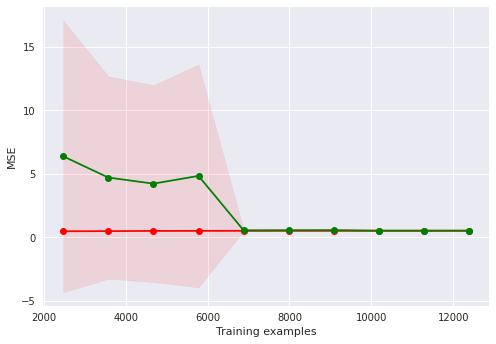

In [20]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = \
    learning_curve(
        lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,
        scoring='neg_mean_squared_error', n_jobs=-1,
        return_times=True, train_sizes=np.linspace(0.2, 1.0, 10))

plot_learning_curve(train_sizes, train_scores, test_scores)

Observe that 
- Both curves have reached a plateau; they are close and fairly high.
- Few instances in the training set means the model can fit them perfectly. But as more instances are added to training set, it becomes impossible for the model to fit the training data perfectly.
- When the model is trained on very few training instances, it is not able of generalizing properly, which is why the validation error is initially quite high. Then as the model learns on more training examples, the training and validation error reduce slowly.

These learning curves are typical of an underfitting model.

We can also study now model training scales as the function of number of training samples

In [21]:
#plot_scalability_curve(train_sizes, fit_times)

As the number of training examples grows, the time to fit also increases.

## Model examination

Let's examine the weight vectors and how much variability exists between them across different cross-validated models.

In [22]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

For this, we will first construct a dataframe of weight vectors and then plot them with box plot.

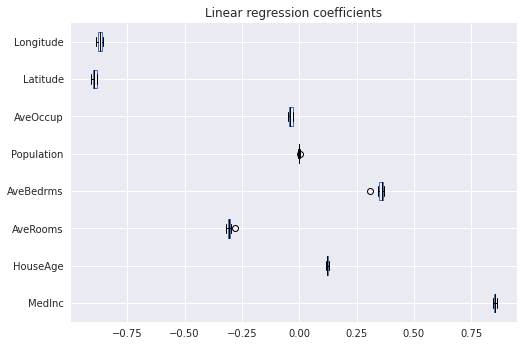

In [23]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results["estimator"]]
weights_df = pd.DataFrame(coefs, columns=feature_names)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_df.plot.box(color=color, vert=False) #, figsize=(6, 16)
_ = plt.title("Linear regression coefficients")

There is not much variability  in weights learned by different models. It can also by standard deviation of weights as seen in std row below:

In [24]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


## Selecting best model

Let's select the model with the lowest cross validated error as the best performing model.

In [25]:
# Let's find out the best model that resulted in the least test error.
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

Let's examine the model coefficients

In [26]:
print("Intercepts (w_0): ", selected_model['lin_reg'].intercept_)
print("Coefficients (w_1, ..., w_m): ", selected_model['lin_reg'].coef_)

Intercepts (w_0):  2.0779898917958657
Coefficients (w_1, ..., w_m):  [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


## Model Performance

Towards this, let's first obtain the predictions for test points in cross validation.

In [27]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(lin_reg_pipeline,
                        train_features, train_labels)

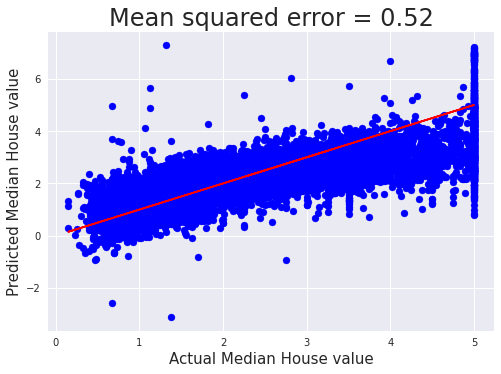

In [28]:
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel('Actual Median House value', size = 15)
plt.ylabel('Predicted Median House value', size=15)
plt.show()

- The model seems to all over the plce in its prdictions for examples with label 5.
- There are some negative predictions. We can fix thsi by adding a constraints on the weights to be positive.

At this stage, we should perform error analysis and check where the predictions are going wrong. We can revisit feature construction, preprocessing or model stages and make the necessary course corrections to get better performance.

# Step #5: Predictions

We can use the best performing model from cross validation for getting predictions on the test set.

In [29]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

We can also obtain predictions using the initial model that we built without cross validation.

In [30]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

# Step #6: Report model performance

We report model performance on the test set.

In [31]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print("R2 score for the best model obtained via cross validation: ", score_cv)
print("R2 score for the model without cv: ", score)

R2 score for the best model obtained via cross validation:  0.5923577635319088
R2 score for the model without cv:  0.5910509795491351


Alternatively we can use any other metric of interest and report performance based on that. For example, the mean squared error is as follows:

In [32]:
mse = mean_squared_error(test_labels, test_predictions)
mse_cv = mean_squared_error(test_labels, test_predictions_cv)

print("MSE for the best model obtained via cross validation: ", mse_cv)
print("MSE for model without cv: ", mse)

MSE for the best model obtained via cross validation:  0.5393995876218523
MSE for model without cv:  0.5411287478470689


The cross validation based model has slightly better MSE than the other model.